In [14]:
"""
Assessment of LANDFIRE EVT (ca. 2016) composition on FRP

This provides an initial assessment of the effects of forest type on FRP in our wildfire database

maxwell.cook@colorado.edu
"""

import os, time
import numpy as np

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'

print("Complete")

Complete


## Calculate the EVT composition from LANDFIRE (ca. 2016) within VIIRS plots

As an initial assessment, we can calculate the forest composition from LANDFIRE and look at the distribution of aspen + FRP. 

In [2]:
# Load the VIIRS 375m2 "plot"
frp_plots = gpd.read_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_plots_fired_events_west_aspen.gpkg'))
print(frp_plots.head())

      VID   LATITUDE   LONGITUDE   ACQ_DATE ACQ_TIME CONFIDENCE    FRP  \
0  876446  37.507347 -112.675858 2020-11-18     1954          n  24.28   
1  876447  37.502945 -112.674408 2020-11-18     1954          n  24.28   
2  876448  37.504166 -112.669052 2020-11-18     1954          n  24.28   
3  876763  37.512333 -112.681885 2020-11-19     1936          n   7.04   
4  876764  37.513638 -112.677109 2020-11-19     1936          n   7.04   

  DAYNIGHT fired_id              ig_date  ... mn_grw_km2  mu_grw_km2  \
0        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
1        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
2        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
3        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   
4        D    44927  2020-11-16 00:00:00  ...   0.214659    4.055308   

            mx_grw_dte      ig_utm_x      ig_utm_y     tot_perim  pct_aspen  \
0  2020-11-17 00:00:00  4.167730e+06 -9.943

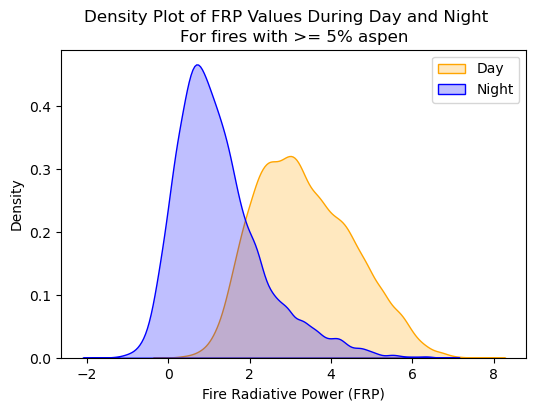

In [23]:
# Filter day and night observations
day_frp = frp_plots[frp_plots['DAYNIGHT'] == 'D']['FRP']
night_frp = frp_plots[frp_plots['DAYNIGHT'] == 'N']['FRP']

# Log scale
day_frp_log = np.log(day_frp[day_frp > 0])
night_frp_log = np.log(night_frp[night_frp > 0])

# Show the distribution of FRP values for day and night observations
plt.figure(figsize=(6, 4))

# Plotting the KDE
sns.kdeplot(day_frp_log, fill=True, color="orange", label="Day")
sns.kdeplot(night_frp_log, fill=True, color="blue", label="Night")

# Adding labels and title
plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.suptitle('Density Plot of FRP Values During Day and Night')  
plt.title('For fires with >= 5% aspen')

plt.legend()

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

del day_frp, night_frp, day_frp_log, night_frp_log

In [4]:
# Calculate the percent cover of EVT types from the LANDFIRE
begin = time.time()

# LANDFIRE EVT 2016 file path
evt_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')

# Zonal statistics
zs = zonal_stats(vectors=frp_plots[['VID','geometry']], raster=evt_path, categorical=True, geojson_out=True)

print(f"Total elapsed time: {round((time.time() - begin))} seconds.")

Total elapsed time: 402 seconds.


In [5]:
# Convert the zonal statistics to a data frame for tidy
stats = gpd.GeoDataFrame(zs).fillna(0) #One column per raster category, and pixel count as value
print(stats.head())
print(len(stats['id'].unique()))

del zs

  id     type                                         properties  \
0  0  Feature  {'VID': 876446, 7011: 32, 7016: 1, 7020: 12, 7...   
1  1  Feature  {'VID': 876447, 7011: 17, 7020: 3, 7051: 109, ...   
2  2  Feature  {'VID': 876448, 7011: 5, 7051: 25, 7052: 56, 7...   
3  3  Feature  {'VID': 876763, 7011: 37, 7016: 1, 7020: 31, 7...   
4  4  Feature  {'VID': 876764, 7011: 3, 7020: 20, 7051: 179, ...   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': (((-1452319...   
1  {'type': 'Polygon', 'coordinates': (((-1452281...   
2  {'type': 'Polygon', 'coordinates': (((-1451795...   
3  {'type': 'Polygon', 'coordinates': (((-1452741...   
4  {'type': 'Polygon', 'coordinates': (((-1452304...   

                                                bbox  
0  (-1453069.902356282, 1735017.7391205789, -1452...  
1  (-1453031.003111099, 1734509.8171300525, -1452...  
2  (-1452545.3110490697, 1734562.6971642193, -145...  
3  (-1453491.9487830054, 1735660.0

In [6]:
# Explode the properties json and calculate the percent cover by class

# First get the unique ID 
stats['VID'] = stats['properties'].apply(lambda x: x.get('VID'))

# Retrieve the other properties (EVT codes)
stats['properties'] = stats['properties'].apply(lambda x: {key: val for key, val in x.items() if key != 'VID'})
stats['properties_list'] = stats['properties'].apply(lambda x: list(x.items()))

# Explode the json
props = stats.explode('properties_list').reset_index(drop=True)

# retrieve the list items as new columns
props[['EVT', 'pixel_count']] = pd.DataFrame(props['properties_list'].tolist(), index=props.index)
props = props[['VID','EVT','pixel_count']].reset_index(drop=True)

# Calculate the percent of each class
total_pixels = props.groupby(props['VID'])['pixel_count'].transform('sum')
props['total_pixels'] = total_pixels
props['pct_cover'] = (props['pixel_count'] / props['total_pixels']) * 100

print(props)

print(len(props['VID'].unique()))
print(props.columns)

del stats, total_pixels

            VID   EVT  pixel_count  total_pixels  pct_cover
0        876446  7011           32           625       5.12
1        876446  7016            1           625       0.16
2        876446  7020           12           625       1.92
3        876446  7051          181           625      28.96
4        876446  7052          137           625      21.92
...         ...   ...          ...           ...        ...
701673  1761738  7192            1           625       0.16
701674  1761738  7193           36           625       5.76
701675  1761738  7199            3           625       0.48
701676  1761738  7200            4           625       0.64
701677  1761738  9001            9           625       1.44

[701678 rows x 5 columns]
65124
Index(['VID', 'EVT', 'pixel_count', 'total_pixels', 'pct_cover'], dtype='object')


In [7]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [9]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
props_df = props.merge(lookup, left_on='EVT', right_on='VALUE', how='left')
print(props_df.head())
print(len(props_df['VID'].unique()))

del lookup

      VID   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0  876446  7011           32           625       5.12   7011   
1  876446  7016            1           625       0.16   7016   
2  876446  7020           12           625       1.92   7020   
3  876446  7051          181           625      28.96   7051   
4  876446  7052          137           625      21.92   7052   

                                            EVT_NAME  EVT_PHYS  \
0           Rocky Mountain Aspen Forest and Woodland  Hardwood   
1           Colorado Plateau Pinyon-Juniper Woodland   Conifer   
2  Inter-Mountain Basins Subalpine Limber-Bristle...   Conifer   
3  Southern Rocky Mountain Dry-Mesic Montane Mixe...   Conifer   
4  Southern Rocky Mountain Mesic Montane Mixed Co...   Conifer   

                                            EVT_GP_N           EVT_CLASS  
0               Aspen Forest, Woodland, and Parkland    Open tree canopy  
1                            Pinyon-Juniper Woodland    Open tree ca

In [12]:
# Join back the VIIRS FRP attributes

print(frp_plots.columns)

# Subset to columns we want to keep
frp_plots = frp_plots[['VID','ACQ_DATE','ACQ_TIME','ACQ_MONTH','ACQ_YEAR','CONFIDENCE','FRP','DAYNIGHT','fired_id']]

# Join back to the dataframe with EVT summary
frp_plots_evt = props_df.merge(frp_plots, left_on='VID', right_on='VID', how='left')

# Check on the results
print(frp_plots_evt.head())
print(len(frp_plots_evt['VID'].unique()))

Index(['VID', 'ACQ_DATE', 'ACQ_TIME', 'ACQ_MONTH', 'ACQ_YEAR', 'CONFIDENCE',
       'FRP', 'DAYNIGHT', 'fired_id'],
      dtype='object')
      VID   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0  876446  7011           32           625       5.12   7011   
1  876446  7016            1           625       0.16   7016   
2  876446  7020           12           625       1.92   7020   
3  876446  7051          181           625      28.96   7051   
4  876446  7052          137           625      21.92   7052   

                                            EVT_NAME  EVT_PHYS  \
0           Rocky Mountain Aspen Forest and Woodland  Hardwood   
1           Colorado Plateau Pinyon-Juniper Woodland   Conifer   
2  Inter-Mountain Basins Subalpine Limber-Bristle...   Conifer   
3  Southern Rocky Mountain Dry-Mesic Montane Mixe...   Conifer   
4  Southern Rocky Mountain Mesic Montane Mixed Co...   Conifer   

                                            EVT_GP_N           EVT_CLASS  \
0   

In [25]:
# Create a subset with just aspen EVT types
# Identify classes with 'aspen' in the EVT_NAME
aspen_classes = frp_plots_evt[frp_plots_evt['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(aspen_classes)

# Now filter to retain just the aspen composition in FRP observations
frp_plots_aspen = frp_plots_evt[frp_plots_evt['EVT_NAME'].isin(aspen_classes)]

# What percent of FRP observations have an aspen component?
len(frp_plots_aspen['VID'].unique()) / len(frp_plots_evt['VID'].unique()) * 100

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland']


79.93980713715374

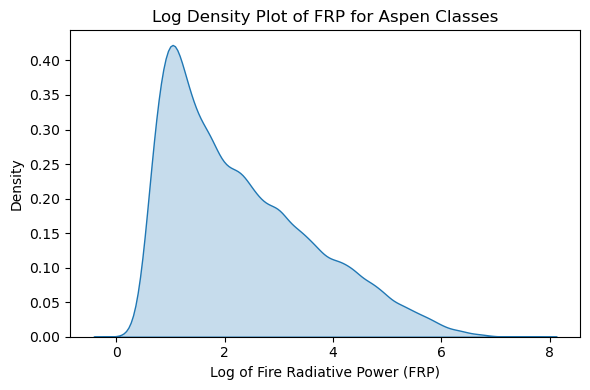

In [47]:
plt.figure(figsize=(6, 4))

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(frp_plots_aspen['FRP']), fill=True)

# Set plot title and axis labels
plt.title('Log Density Plot of FRP for EVT')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
plt.show()

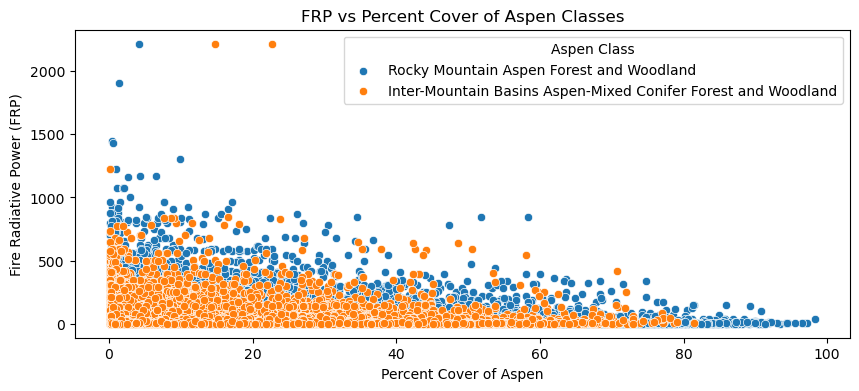

In [65]:
plt.figure(figsize=(10, 4))

frp_plots_aspen_ = frp_plots_aspen[frp_plots_aspen['FRP'] > 0]

for aspen_class in aspen_classes:
    subset = frp_plots_aspen_[frp_plots_aspen_['EVT_NAME'] == aspen_class]
    sns.scatterplot(x='pct_cover', y='FRP', data=subset, label=aspen_class)

plt.title('FRP vs Percent Cover of Aspen Classes')
plt.xlabel('Percent Cover of Aspen')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='Aspen Class')

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

del frp_plots_aspen_

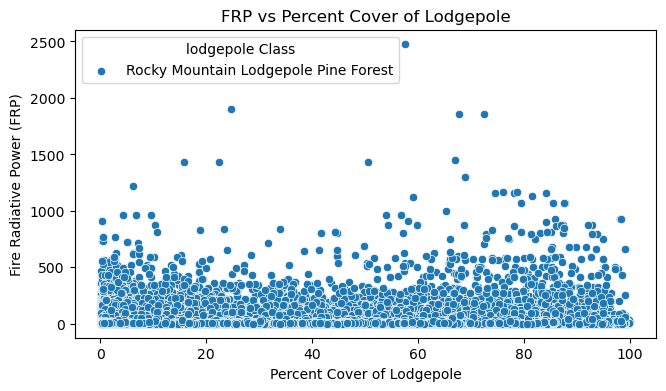

In [44]:
# Create a subset with just aspen EVT types
# Identify classes with 'aspen' in the EVT_NAME
lodgepole = frp_plots_evt[frp_plots_evt['EVT_NAME'] == "Rocky Mountain Lodgepole Pine Forest"]

plt.figure(figsize=(7.5, 4))

sns.scatterplot(x='pct_cover', y='FRP', data=lodgepole, label="Rocky Mountain Lodgepole Pine Forest")

plt.title('FRP vs Percent Cover of Lodgepole')
plt.xlabel('Percent Cover of Lodgepole')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='lodgepole Class')

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

52.47345919436245
69.68820797344235


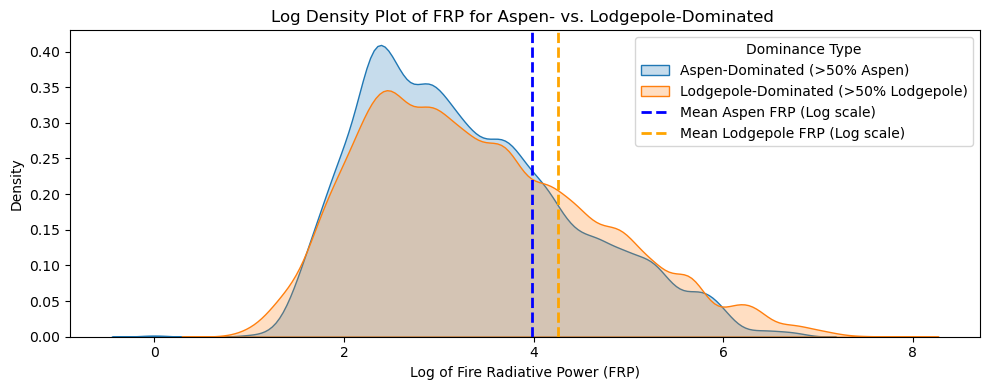

In [67]:
lodgepole_class = "Rocky Mountain Lodgepole Pine Forest"
aspen_classes = ['Rocky Mountain Aspen Forest and Woodland',
                 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland']

# Create a new DataFrame to calculate percent cover for each EVT_NAME per VID
evt_cover = (
    frp_plots_evt[['VID', 'EVT_NAME', 'pct_cover']]
    .pivot_table(index='VID', columns='EVT_NAME', values='pct_cover', aggfunc='sum', fill_value=0)
)

# Now, create the 'pct_aspen' and 'pct_lodgepole' columns by summing across the relevant EVT_NAMEs
evt_cover['pct_aspen'] = evt_cover[aspen_classes].sum(axis=1)
evt_cover['pct_lodgepole'] = evt_cover[lodgepole_class]

frp_plots_evt_ = frp_plots_evt.merge(evt_cover[['pct_aspen', 'pct_lodgepole']], on='VID')

# Only daytime observations
frp_plots_evt_ = frp_plots_evt_[frp_plots_evt_['DAYNIGHT'] == 'D']

# Plot the density distribution

aspen_dominated = frp_plots_evt_[frp_plots_evt_['pct_aspen'] > 50]
lodgepole_dominated = frp_plots_evt_[frp_plots_evt_['pct_lodgepole'] > 50]

print(aspen_dominated['FRP'].mean())
print(lodgepole_dominated['FRP'].mean())

plt.figure(figsize=(10, 4))

# Plot the KDE for aspen-dominated observations
# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(aspen_dominated['FRP']), fill=True, label='Aspen-Dominated (>50% Aspen)')
sns.kdeplot(np.log1p(lodgepole_dominated['FRP']), fill=True, label='Lodgepole-Dominated (>50% Lodgepole)')

# Draw a dashed line at the mean FRP value 
plt.axvline(np.log1p(aspen_dominated['FRP'].mean()), color='blue', linestyle='dashed', linewidth=2, label=f'Mean Aspen FRP (Log scale)')
plt.axvline(np.log1p(lodgepole_dominated['FRP'].mean()), color='orange', linestyle='dashed', linewidth=2, label=f'Mean Lodgepole FRP (Log scale)')


# Set plot title and axis labels
plt.title('Log Density Plot of FRP for Aspen- vs. Lodgepole-Dominated ')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')

# Place the legend outside the plot to avoid covering the data
plt.legend(title='Dominance Type', loc='upper right')

plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_vs_lodgepole.png'), dpi=300, bbox_inches='tight')

plt.show()

Aspen_Cover_Class
Medium    182649
Low        61246
High       33107
Name: count, dtype: int64


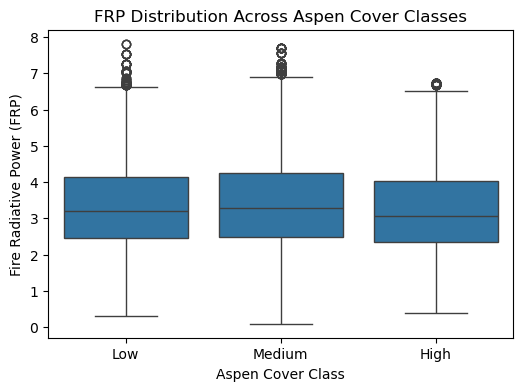

In [74]:
# Determine the quantiles
quantiles = frp_plots_evt_['pct_aspen'].quantile([0.22, 0.88])

# Define the bins and labels
bins = [-np.inf, quantiles[0.22], quantiles[0.88], np.inf]
labels = ['Low', 'Medium', 'High']

# Create a new column in the DataFrame with the cover categories
frp_plots_evt_['Aspen_Cover_Class'] = pd.cut(frp_plots_evt_['pct_aspen'], bins=bins, labels=labels)

# Verify the categories
print(frp_plots_evt_['Aspen_Cover_Class'].value_counts())

# Now create the boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x='Aspen_Cover_Class', y='log_FRP', data=frp_plots_evt_, order=['Low', 'Medium', 'High'])
plt.title('FRP Distribution Across Aspen Cover Classes')
plt.xlabel('Aspen Cover Class')
plt.ylabel('Fire Radiative Power (FRP)')
plt.show()

## Investigate the relationship between EVT (class, percent cover, etc) on FRP

In [39]:
# Create a "pct_forest" column using the EVT_PHYS
print(frp_plots_evt['EVT_CLASS'].unique())

['Open tree canopy' 'Closed tree canopy' 'Shrubland'
 'No Dominant Lifeform' 'Herbaceous-grassland' 'Sparsely vegetated'
 'Sparse tree canopy' 'Non-vegetated' 'Dwarf-shrubland'
 'Herbaceous-shrub-steppe']
